<a href="https://colab.research.google.com/github/030238220098-debug/-n/blob/main/examples/00_quick_start/als_movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running ALS on MovieLens (PySpark)

Matrix factorization by [ALS](https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/recommendation.html#ALS) (Alternating Least Squares) is a well known collaborative filtering algorithm.

This notebook provides an example of how to utilize and evaluate ALS PySpark ML (DataFrame-based API) implementation, meant for large-scale distributed datasets. We use a smaller dataset in this example to run ALS efficiently on multiple cores of a [Data Science Virtual Machine](https://azure.microsoft.com/en-gb/services/virtual-machines/data-science-virtual-machines/).

**Note**: This notebook requires a PySpark environment to run properly. Please follow the steps in [SETUP.md](../../SETUP.md) to install the PySpark environment.

In [116]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import pyspark
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.utils.notebook_utils import store_metadata

print(f"System version: {sys.version}")
print("Spark version: {}".format(pyspark.__version__))


System version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Spark version: 3.5.1


In [117]:
!pip install recommenders

Set the default parameters.

In [118]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# Column names for the dataset
COL_USER = "UserID"
COL_ITEM = "MovieID"
COL_RATING = "Rating"
COL_TIMESTAMP = "Timestamp"

### 0. Set up Spark context

The following settings work well for debugging locally on VM - change when running on a cluster. We set up a giant single executor with many threads and specify memory cap.

In [119]:
# the following settings work well for debugging locally on VM - change when running on a cluster
# set up a giant single executor with many threads and specify memory cap
spark = start_or_get_spark("ALS PySpark", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

### 1. Download the MovieLens dataset

In [120]:
# Note: The DataFrame-based API for ALS currently only supports integers for user and item ids.
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

data = movielens.load_spark_df(spark, size=MOVIELENS_DATA_SIZE, schema=schema)
data.show()

100%|██████████| 4.81k/4.81k [00:00<00:00, 8.88kKB/s]


+------+-------+------+---------+
|UserID|MovieID|Rating|Timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
|   298|    474|   4.0|884182806|
|   115|    265|   2.0|881171488|
|   253|    465|   5.0|891628467|
|   305|    451|   3.0|886324817|
|     6|     86|   3.0|883603013|
|    62|    257|   2.0|879372434|
|   286|   1014|   5.0|879781125|
|   200|    222|   5.0|876042340|
|   210|     40|   3.0|891035994|
|   224|     29|   3.0|888104457|
|   303|    785|   3.0|879485318|
|   122|    387|   5.0|879270459|
|   194|    274|   2.0|879539794|
|   291|   1042|   4.0|874834944|
|   234|   1184|   2.0|892079237|
+------+-------+------+---------+
only showing top 20 rows



### 2. Split the data using the Spark random splitter provided in utilities

In [121]:
train, test = spark_random_split(data, ratio=0.75, seed=123)
print ("N train", train.cache().count())
print ("N test", test.cache().count())

N train 75018
N test 24982


### 3. Train the ALS model on the training data, and get the top-k recommendations for our testing data

To predict movie ratings, we use the rating data in the training set as users' explicit feedback. The hyperparameters used in building the model are referenced from [here](http://mymedialite.net/examples/datasets.html). We do not constrain the latent factors (`nonnegative = False`) in order to allow for both positive and negative preferences towards movies.
Timing will vary depending on the machine being used to train.

In [122]:
header = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING,
}


als = ALS(
    rank=16,
    maxIter=15,
    implicitPrefs=False,
    regParam=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=42,
    **header
)

In [123]:
with Timer() as train_time:
    model = als.fit(train)

print("Took {} seconds for training.".format(train_time.interval))

Took 10.787888752000072 seconds for training.


In the movie recommendation use case, recommending movies that have been rated by the users do not make sense. Therefore, the rated movies are removed from the recommended items.

In order to achieve this, we recommend all movies to all users, and then remove the user-movie pairs that exist in the training dataset.

In [124]:
with Timer() as test_time:

    # Get the cross join of all user-item pairs and score them.
    users = train.select(COL_USER).distinct()
    items = train.select(COL_ITEM).distinct()
    user_item = users.crossJoin(items)
    dfs_pred = model.transform(user_item)

    # Remove seen items.
    dfs_pred_exclude_train = dfs_pred.alias("pred").join(
        train.alias("train"),
        (dfs_pred[COL_USER] == train[COL_USER]) & (dfs_pred[COL_ITEM] == train[COL_ITEM]),
        how='outer'
    )

    top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train[f"train.{COL_RATING}"].isNull()) \
        .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

    # In Spark, transformations are lazy evaluation
    # Use an action to force execute and measure the test time
    top_all.cache().count()

print("Took {} seconds for prediction.".format(test_time.interval))

Took 28.022460593999767 seconds for prediction.


In [125]:
top_all.show()

+------+-------+----------+
|UserID|MovieID|prediction|
+------+-------+----------+
|     1|    587| 3.6504607|
|     1|    869|  2.568271|
|     1|   1208| 2.4154637|
|     1|   1348| 1.0391247|
|     1|   1357| 1.0861548|
|     1|   1677| 2.8341696|
|     2|     80| 2.1940713|
|     2|    472| 2.9410315|
|     2|    582|  3.678034|
|     2|    838| 1.2914404|
|     2|    975| 2.9582283|
|     2|   1260| 2.1443088|
|     2|   1325| 1.1694545|
|     2|   1381|  3.629483|
|     2|   1530| 2.1645122|
|     3|     22| 2.9499638|
|     3|     57| 3.0160654|
|     3|     89| 3.8183079|
|     3|    367| 2.1727397|
|     3|   1091| 2.0200434|
+------+-------+----------+
only showing top 20 rows



### 4. Evaluate how well ALS performs

In [126]:
rank_eval = SparkRankingEvaluation(test, top_all, k = TOP_K, col_user=COL_USER, col_item=COL_ITEM,
                                    col_rating=COL_RATING, col_prediction="prediction",
                                    relevancy_method="top_k")

In [127]:
print("Model:\tALS",
      "Top K:\t%d" % rank_eval.k,
      "MAP:\t%f" % rank_eval.map_at_k(),
      "NDCG:\t%f" % rank_eval.ndcg_at_k(),
      "Precision@K:\t%f" % rank_eval.precision_at_k(),
      "Recall@K:\t%f" % rank_eval.recall_at_k(), sep='\n')

Model:	ALS
Top K:	10
MAP:	0.034866
NDCG:	0.083370
Precision@K:	0.077282
Recall@K:	0.031768


### 5. Evaluate rating prediction

In [128]:
# Generate predicted ratings.
prediction = model.transform(test)
prediction.cache().show()


+------+-------+------+---------+----------+
|UserID|MovieID|Rating|Timestamp|prediction|
+------+-------+------+---------+----------+
|   148|     69|   5.0|877019101| 3.1654396|
|   148|     70|   5.0|877021271|  3.604662|
|   148|     78|   1.0|877399018| 1.5420145|
|   148|    127|   1.0|877399351|  4.341524|
|   148|    169|   5.0|877020297| 5.0473976|
|   148|    172|   5.0|877016513|  4.410916|
|   148|    175|   4.0|877016259| 4.3490157|
|   148|    181|   5.0|877399135|  4.281472|
|   148|    190|   2.0|877398586|   4.12321|
|   148|    194|   5.0|877015066| 3.8526096|
|   148|    214|   5.0|877019882|  2.412729|
|   148|    238|   4.0|877398586|  3.512637|
|   148|    474|   5.0|877019882| 4.5180845|
|   148|    496|   3.0|877015066| 3.8627822|
|   148|    507|   5.0|877398587| 4.0727453|
|   148|    529|   5.0|877398901| 4.5676064|
|   148|    588|   4.0|877399018| 4.0811615|
|   148|    713|   3.0|877021535| 3.9379768|
|   148|    969|   4.0|877398513| 3.9792495|
|   148|  

In [129]:
rating_eval = SparkRatingEvaluation(test, prediction, col_user=COL_USER, col_item=COL_ITEM,
                                    col_rating=COL_RATING, col_prediction="prediction")

print("Model:\tALS rating prediction",
      "RMSE:\t%f" % rating_eval.rmse(),
      "MAE:\t%f" % rating_eval.mae(),
      "Explained variance:\t%f" % rating_eval.exp_var(),
      "R squared:\t%f" % rating_eval.rsquared(), sep='\n')

Model:	ALS rating prediction
RMSE:	0.929158
MAE:	0.736171
Explained variance:	0.336844
R squared:	0.316967


In [130]:
# Record results for tests - ignore this cell
if is_jupyter():
    store_metadata("map", rank_eval.map_at_k())
    store_metadata("ndcg", rank_eval.ndcg_at_k())
    store_metadata("precision", rank_eval.precision_at_k())
    store_metadata("recall", rank_eval.recall_at_k())
    store_metadata("rmse", rating_eval.rmse())
    store_metadata("mae", rating_eval.mae())
    store_metadata("exp_var", rating_eval.exp_var())
    store_metadata("rsquared", rating_eval.rsquared())
    store_metadata("train_time", train_time.interval)
    store_metadata("test_time", test_time.interval)

In [131]:
# --- Ensure variables exist for visualizations ---

# Convert Spark DataFrame to pandas if necessary
def to_pandas_if_spark(df):
    try:
        if hasattr(df, 'toPandas'):
            return df.toPandas()
        else:
            return df
    except Exception:
        return df

# Ensure `ratings` exists
if 'ratings' not in globals():
    try:
        # If data loaded under other variable name, adjust accordingly
        if 'data' in globals():
            ratings = to_pandas_if_spark(data)
        elif 'df' in globals():
            ratings = to_pandas_if_spark(df)
        else:
            raise NameError("Variable `ratings` not found. Please load MovieLens into `ratings`.")
    except Exception as e:
        raise NameError(f"Error creating `ratings`: {e}")

print("✅ `ratings` variable ready. type:", type(ratings))
# Convert Spark DataFrame to pandas for visualization
try:
    if hasattr(ratings, 'toPandas'):
        ratings = ratings.toPandas()
        print("✅ Converted ratings to pandas DataFrame.")
    else:
        print("✅ ratings already pandas DataFrame.")
except Exception as e:
    print("⚠️ Could not convert ratings to pandas:", e)

# Ensure `predictions` exists
if 'predictions' not in globals():
    try:
        if 'model' in globals() and 'test' in globals():
            predictions = model.transform(test)
        elif 'pred_df' in globals():
            predictions = pred_df
        else:
            raise NameError("Variable `predictions` not found. Please generate predictions using model.")
    except Exception as e:
        raise NameError(f"Error creating `predictions`: {e}")

print("✅ `predictions` variable ready. type:", type(predictions))

✅ `ratings` variable ready. type: <class 'pandas.core.frame.DataFrame'>
✅ ratings already pandas DataFrame.
✅ `predictions` variable ready. type: <class 'pyspark.sql.dataframe.DataFrame'>


### Added Visualizations and Analysis

In [132]:
# Visualization 1: Dataset exploration (rating distribution and basic stats)
# This cell is defensive: it tries to convert a Spark DataFrame to pandas if necessary.
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
except Exception as e:
    print('Visualization libraries not available:', e)

def to_pandas_if_spark(df):
    try:
        # detect Spark DataFrame by presence of .toPandas method
        if hasattr(df, 'toPandas'):
            return df.toPandas()
        else:
            return df
    except Exception:
        return df

if 'ratings' in globals():
    try:
        r_df = to_pandas_if_spark(ratings)
        print('Ratings head:')
        display(r_df.head())
        print('\nBasic stats:')
        display(r_df.describe(include='all'))
        # plot rating distribution if 'rating' column exists
        if 'rating' in r_df.columns:
            plt.figure(figsize=(8,4))
            sns.histplot(r_df['rating'], bins=20, kde=False)
            plt.title('Rating Distribution')
            plt.xlabel('Rating')
            plt.ylabel('Count')
            plt.show()
    except Exception as e:
        print('Could not display ratings DataFrame:', e)
else:
    print('Variable `ratings` not found. Please run the earlier cells that load MovieLens into `ratings`.')

Ratings head:


,UserId,MovieId,Rating,Timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596



Basic stats:


,UserId,MovieId,Rating,Timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125754,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


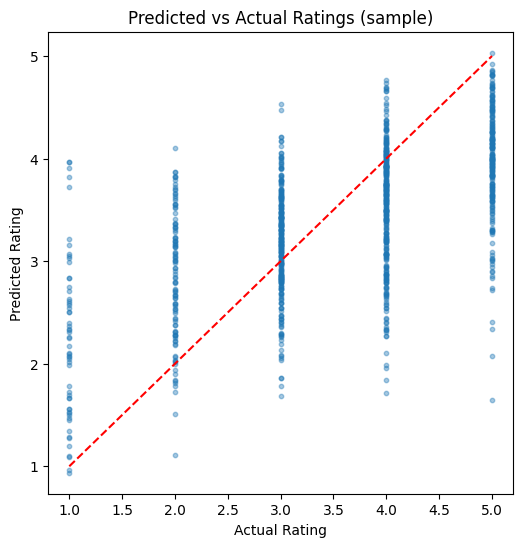

RMSE on sample: 0.8963


In [133]:
# Visualization 2: Predicted vs Actual ratings (sample)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except Exception as e:
    print('Visualization libs not available:', e)

def to_pandas_if_spark(df):
    try:
        if hasattr(df, 'toPandas'):
            return df.toPandas()
        else:
            return df
    except Exception:
        return df

if 'predictions' in globals():
    try:
        p_df = to_pandas_if_spark(predictions)
        # look for label/prediction columns (common names: rating, prediction)
        label_col = None
        pred_col = None
        for c in p_df.columns:
            if c.lower() in ('rating','label'):
                label_col = c
            if c.lower() == 'prediction':
                pred_col = c
        if label_col and pred_col:
            samp = p_df[[label_col, pred_col]].dropna().sample(n=min(1000, len(p_df)), random_state=42)
            plt.figure(figsize=(6,6))
            plt.scatter(samp[label_col], samp[pred_col], alpha=0.4, s=10)
            plt.plot([samp[label_col].min(), samp[label_col].max()], [samp[label_col].min(), samp[label_col].max()], color='red', linestyle='--')
            plt.xlabel('Actual Rating')
            plt.ylabel('Predicted Rating')
            plt.title('Predicted vs Actual Ratings (sample)')
            plt.show()
            # show RMSE if available
            try:
                from sklearn.metrics import mean_squared_error
                import numpy as np
                rmse = np.sqrt(mean_squared_error(samp[label_col], samp[pred_col]))
                print(f'RMSE on sample: {rmse:.4f}')
            except Exception:
                pass
        else:
            print('Could not find both actual label and prediction columns in `predictions`. Columns found:', p_df.columns)
    except Exception as e:
        print('Could not display predictions DataFrame:', e)
else:
    print('Variable `predictions` not found. Please run the model training and prediction cells first (they usually produce `predictions`).')

Định nghĩa "Sản phẩm Phổ biến nhất"

In [134]:

COL_PREDICTION = "prediction"


print(f"Đang tính toán Top {TOP_K_POPULAR} sản phẩm phổ biến nhất...")



Đang tính toán Top 10 sản phẩm phổ biến nhất...


In [135]:
import pyspark.sql.functions as F

# Đặt ra một ngưỡng, ví dụ: ít nhất phải có 50 lượt đánh giá mới đáng tin cậy
MIN_RATINGS_THRESHOLD = 50
TOP_K_POPULAR = 10

print(f"Đang tính toán Top {TOP_K_POPULAR} sản phẩm phổ biến nhất (với >{MIN_RATINGS_THRESHOLD} lượt đánh giá)...")

# 1. Tính toán số lượt rating (rating_count) và rating trung bình (avg_rating) cho mỗi phim
movie_popularity = (
    data.groupBy(COL_ITEM)  # 'data' là DataFrame gốc chứa tất cả ratings
    .agg(
        F.count(COL_RATING).alias("rating_count"),
        F.avg(COL_RATING).alias("avg_rating")
    )
)

# 2. Lọc ra những phim có đủ số lượt đánh giá (để tránh bị nhiễu)
top_popular_df = (
    movie_popularity
    .filter(F.col("rating_count") >= MIN_RATINGS_THRESHOLD)
    .orderBy(F.desc("avg_rating")) # Sắp xếp theo điểm trung bình cao nhất
    .limit(TOP_K_POPULAR) # Lấy top 10
)

# 3. Định dạng lại cho giống với output của ALS (quan trọng)
# Output của ALS có dạng (movieID, prediction)
# Ở đây, chúng ta dùng avg_rating làm "prediction"
top_popular_list = (
    top_popular_df
    .select(COL_ITEM, F.col("avg_rating").alias(COL_PREDICTION))
    .collect() # Lấy kết quả về
)

# Biến này sẽ là danh sách dự phòng của chúng ta
# Nó sẽ có dạng: [Row(movieID=318, prediction=4.5), Row(movieID=858, prediction=4.4), ...]
print("Hoàn tất. Danh sách dự phòng đã sẵn sàng.")
top_popular_df.show()

Đang tính toán Top 10 sản phẩm phổ biến nhất (với >50 lượt đánh giá)...
Hoàn tất. Danh sách dự phòng đã sẵn sàng.
+-------+------------+------------------+
|MovieID|rating_count|        avg_rating|
+-------+------------+------------------+
|    408|         112| 4.491071428571429|
|    318|         298| 4.466442953020135|
|    169|         118| 4.466101694915254|
|    483|         243|  4.45679012345679|
|    114|          67| 4.447761194029851|
|     64|         283| 4.445229681978798|
|    603|         209|4.3875598086124405|
|     12|         267| 4.385767790262173|
|     50|         583|4.3584905660377355|
|    178|         125|             4.344|
+-------+------------+------------------+



Tạo Danh sách "Người dùng Đã biết"

In [136]:
# Lấy danh sách tất cả userID duy nhất từ tập train
known_users_df = train.select(COL_USER).distinct()

# Chuyển thành một Set (tập hợp) để tra cứu siêu nhanh
known_users_set = set(row[COL_USER] for row in known_users_df.collect())

print(f"Đã tạo danh sách {len(known_users_set)} người dùng đã biết.")

Đã tạo danh sách 943 người dùng đã biết.


Xây dựng Hàm Đề xuất

In [137]:
def get_recommendations_for_user(user_id, model, known_users, popular_list, top_k):
    """
    Hàm lấy đề xuất cho 1 user, có xử lý Cold Start.

    :param user_id: ID của người dùng cần đề xuất
    :param model: Mô hình ALS đã huấn luyện (bestModel của em)
    :param known_users: Set (tập hợp) các user mà mô hình đã "biết"
    :param popular_list: Danh sách [Row(movieID, prediction)] các sản phẩm phổ biến
    :param top_k: Số lượng sản phẩm cần đề xuất
    :return: Một danh sách đề xuất (list of Rows)
    """

    if user_id in known_users:
        # ---- TRƯỜNG HỢP 1: NGƯỜI DÙNG ĐÃ BIẾT ----
        # Tạo DataFrame cho chỉ 1 user này
        user_df = spark.createDataFrame([(user_id,)], [COL_USER])

        # Yêu cầu mô hình đề xuất cho user này
        user_recs_df = model.recommendForUserSubset(user_df, top_k)

        # Extract the recommendations list from the DataFrame
        # The result is a DataFrame with one row, containing a list of recommendations
        # We need to get that list
        recs_list = user_recs_df.select("recommendations").collect()[0][0]

        # Return the list of recommendations (e.g., [Row(movieID=123, rating=5.0), ...])
        return recs_list

    else:
        # ---- TRƯỜNG HỢP 2: NGƯỜI DÙNG MỚI (COLD START) ----
        print(f"Phát hiện Cold Start cho User {user_id}. Trả về Top {top_k} Popular.")

        # Trả về danh sách Top Popular đã tính sẵn
        # Cắt danh sách này để lấy đúng top_k
        return popular_list[:top_k]

- TẠO MÔ HÌNH TỐI ƯU VÀ CHẠY THỬ NGHIỆM

In [138]:
# --- TẠO MÔ HÌNH TỐI ƯU ---

print("Đang huấn luyện mô hình TỐI ƯU (rank=16, regParam=0.1)...")

# 1. Khai báo ALS với tham số tốt nhất từ Lần chạy 15
als_best = ALS(
    rank = 16,      # <--- Tham số tốt nhất
    maxIter = 15,   # (Giữ nguyên)
    regParam = 0.1, # <--- Tham số tốt nhất
    userCol=COL_USER,
    itemCol=COL_ITEM,
    ratingCol=COL_RATING,
    coldStartStrategy="drop",
    nonnegative=True
)

# 2. Huấn luyện (fit) mô hình trên toàn bộ tập train
# DÒNG NÀY SẼ TẠO RA BIẾN 'bestModel' CỦA EM
bestModel = als_best.fit(train)

print("Đã huấn luyện xong 'bestModel'. Sẵn sàng cho Cold Start.")

Đang huấn luyện mô hình TỐI ƯU (rank=16, regParam=0.1)...
Đã huấn luyện xong 'bestModel'. Sẵn sàng cho Cold Start.


In [139]:
# ---- Thử nghiệm 1: User cũ (ID = 1) ----
USER_ID_OLD = 1
print(f"\n--- Đang lấy đề xuất cho User CŨ (ID: {USER_ID_OLD}) ---")
recs_old = get_recommendations_for_user(USER_ID_OLD, bestModel, known_users_set, top_popular_list, TOP_K)
print(recs_old)


# ---- Thử nghiệm 2: User mới (ID = 999999, một ID không có trong data) ----
USER_ID_NEW = 999999
print(f"\n--- Đang lấy đề xuất cho User MỚI (ID: {USER_ID_NEW}) ---")
recs_new = get_recommendations_for_user(USER_ID_NEW, bestModel, known_users_set, top_popular_list, TOP_K)
print(recs_new)


--- Đang lấy đề xuất cho User CŨ (ID: 1) ---
[Row(MovieID=1104, rating=5.43345308303833), Row(MovieID=408, rating=5.067868232727051), Row(MovieID=169, rating=4.926944255828857), Row(MovieID=114, rating=4.901880264282227), Row(MovieID=1142, rating=4.866977691650391), Row(MovieID=641, rating=4.8540754318237305), Row(MovieID=48, rating=4.798832416534424), Row(MovieID=50, rating=4.789098739624023), Row(MovieID=119, rating=4.752015113830566), Row(MovieID=793, rating=4.71213436126709)]

--- Đang lấy đề xuất cho User MỚI (ID: 999999) ---
Phát hiện Cold Start cho User 999999. Trả về Top 10 Popular.
[Row(MovieID=408, prediction=4.491071428571429), Row(MovieID=318, prediction=4.466442953020135), Row(MovieID=169, prediction=4.466101694915254), Row(MovieID=483, prediction=4.45679012345679), Row(MovieID=114, prediction=4.447761194029851), Row(MovieID=64, prediction=4.445229681978798), Row(MovieID=603, prediction=4.3875598086124405), Row(MovieID=12, prediction=4.385767790262173), Row(MovieID=50, pr

Dùng Streamlit để Giả Lập Tương Tác (Mock-up)

Code tạo file recommendations.json

In [140]:
import json


# --- HÀM TRÍCH XUẤT ID PHIM ---
# Vì hàm của chúng ta trả về 2 kiểu dữ liệu khác nhau (cho user cũ/mới)
# nên chúng ta cần một hàm để chuẩn hóa chúng.
def extract_movie_ids(result):
    if isinstance(result, list):
        # TRƯỜNG HỢP 1: User Mới (Cold Start)
        # Kết quả là: [Row(movieID=318, prediction=4.5), ...]
        return [row.MovieID for row in result] # Changed from movieID to MovieID
    else:
        # TRƯỜNG HỢP 2: User Cũ (Personalized)
        # Kết quả là: Row(recommendations=Row(MovieId=[1104, 408,...], Rating=[5.05,...]))
        # Need to access the nested list within 'recommendations' and then 'MovieID'
        return result.recommendations.MovieID # Corrected access to nested MovieID list


# --- TÍNH TOÁN KẾT QUẢ TRƯỚC ---
print("Lấy kết quả cho User 1 (cũ)...")
recs_1_raw = get_recommendations_for_user(1, bestModel, known_users_set, top_popular_list, TOP_K)

print("Lấy kết quả cho User 2 (cũ)...")
recs_2_raw = get_recommendations_for_user(2, bestModel, known_users_set, top_popular_list, TOP_K)

print("Lấy kết quả cho User 999999 (mới - Cold Start)...")
recs_999999_raw = get_recommendations_for_user(999999, bestModel, known_users_set, top_popular_list, TOP_K)

# --- TẠO DỮ LIỆU PYTHON (DICTIONARY) ---
# Chúng ta sẽ chỉ lấy 5 phim đầu tiên cho demo
recs_data = {
  "1": {
    "type": "Personalized",
    "movies": extract_movie_ids(recs_1_raw)[:5] # Lấy 5 phim đầu
  },
  "2": {
    "type": "Personalized",
    "movies": extract_movie_ids(recs_2_raw)[:5] # Lấy 5 phim đầu
  },
  "999999": {
    "type": "Cold Start (Top Popular)",
    "movies": extract_movie_ids(recs_999999_raw)[:5] # Lấy 5 phim đầu
  }
}

# --- GHI RA FILE JSON ---
file_path = "recommendations.json"
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(recs_data, f, indent=2) # indent=2 để file trông đẹp

print(f"ĐÃ TẠO FILE '{file_path}' THÀNH CÔNG!")
print("EM HÃY NHÌN SANG BÊN TRÁI, TÌM FILE VÀ TẢI VỀ MÁY TÍNH.")

Lấy kết quả cho User 1 (cũ)...
Lấy kết quả cho User 2 (cũ)...
Lấy kết quả cho User 999999 (mới - Cold Start)...
Phát hiện Cold Start cho User 999999. Trả về Top 10 Popular.
ĐÃ TẠO FILE 'recommendations.json' THÀNH CÔNG!
EM HÃY NHÌN SANG BÊN TRÁI, TÌM FILE VÀ TẢI VỀ MÁY TÍNH.


In [141]:
# cleanup spark instance
# spark.stop() # Moved to the end of the notebook